Realization: I don't actually need to take the number of steps very large...

In [1]:
from benchmark.testsystems import alanine_constrained
from benchmark.testsystems import NonequilibriumSimulator
from benchmark.integrators import LangevinSplittingIntegrator

from benchmark import simulation_parameters
temperature = simulation_parameters['temperature']
from simtk import unit
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

OpenMM version:  7.2.0.dev-fb607c7
OpenMM version:  7.2.0.dev-fb607c7
	Removing CMMotionRemover
	Removing CMMotionRemover
Desired platform not supported
Desired platform not supported
Desired platform not supported
Desired platform not supported
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported


In [2]:
def integrator_factory(scheme='V R O R V'):
    return LangevinSplittingIntegrator(splitting=scheme,
                                         temperature=temperature,
                                         collision_rate=1.0 / unit.picosecond)

In [3]:
# what's the one-step shadow work distribution at steady-state? is it a lot less difficult than the
# 1000-step work distribution?

In [18]:
from benchmark.evaluation.compare_near_eq_and_exact import stdev_log_rho_pi

In [19]:
integrator = integrator_factory()

In [20]:
integrator.setStepSize(4.5 * unit.femtosecond)

In [21]:
noneq_sim = NonequilibriumSimulator(alanine_constrained, integrator)

In [22]:
x0 = noneq_sim.sample_x_from_equilibrium()
v0 = noneq_sim.sample_v_given_x(x0)

In [28]:
noneq_sim.integrator.getStepSize().value_in_unit(unit.femtosecond)

4.500000000000001

In [24]:
from tqdm import tqdm
Ws = [noneq_sim.accumulate_shadow_work(x0, v0, 1000)['W_shad'] for _ in tqdm(range(1000))]

100%|██████████| 1000/1000 [01:16<00:00, 12.79it/s]


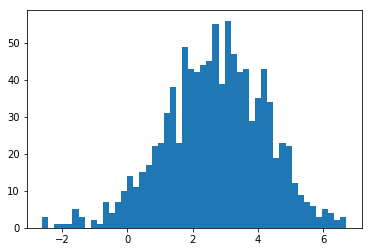

In [26]:
plt.hist(Ws, bins=50);

In [30]:
noneq_sim.simulation.step(10000)

In [31]:
from benchmark.testsystems.bookkeepers import get_state_as_mdtraj

In [33]:
x0 = get_state_as_mdtraj(noneq_sim.simulation)

In [35]:
v0 = noneq_sim.simulation.context.getState(getVelocities=True).getVelocities(asNumpy=True)

In [55]:
from tqdm import tqdm

n_steps_list = [1,2,3,4,5,10,25,50,100]
all_Ws = []

for n_steps in n_steps_list:
    Ws = np.array([noneq_sim.accumulate_shadow_work(x0, v0, n_steps)['W_shad'] for _ in tqdm(range(10000))])
    all_Ws.append(Ws)

100%|██████████| 10000/10000 [01:19<00:00, 125.72it/s]


In [56]:
import seaborn.apionly as sns
colors = sns.color_palette("GnBu_d", n_colors=len(n_steps_list))

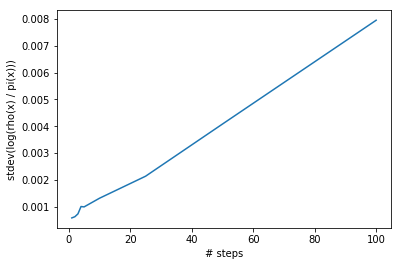

In [81]:
stdevs = np.array([stdev_log_rho_pi(w) for w in all_Ws])
plt.plot(n_steps_list, stdevs)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('# steps')
plt.ylabel('stdev(log(rho(x) / pi(x)))')

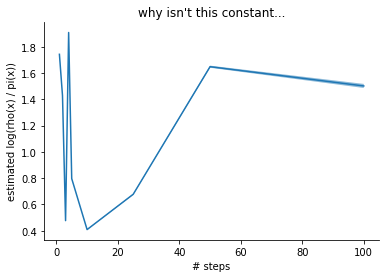

In [72]:
ax = plt.subplot(111)
means = np.array([np.log(np.mean(np.exp(-w))) for w in all_Ws])
plt.plot(n_steps_list, means)
plt.fill_between(n_steps_list, means - 1.96 * stdevs, means + 1.96 * stdevs, alpha=0.5)
#plt.xscale('log')
#plt.yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('# steps')
plt.ylabel('estimated log(rho(x) / pi(x))')
plt.title("why isn't this constant...")

([], <a list of 0 Text yticklabel objects>)

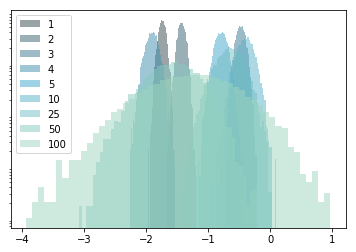

In [62]:
for i, (n_steps, Ws) in enumerate(zip(n_steps_list, all_Ws)):
    plt.hist(Ws, bins=50, alpha=0.5, color=colors[i], label=str(n_steps), normed=True);
plt.legend(loc='best')
plt.yscale('log')
plt.yticks([])

/Users/joshuafass/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


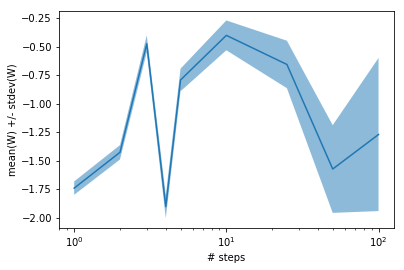

In [80]:
x_ = np.array(n_steps_list)
y_ = np.array([np.mean(Ws) for Ws in all_Ws])
y_stdev = np.array([np.std(Ws) for Ws in all_Ws])

plt.plot(x_, y_)
plt.fill_between(x_, y_ - y_stdev, y_ + y_stdev, alpha=0.5)

plt.legend(loc='best')
#plt.yscale('log')
#plt.yticks([])
plt.xscale('log')

plt.xlabel('# steps')
plt.ylabel('mean(W) +/- stdev(W)')

In [ ]:
# okay, let's see what 